In [2]:
import numpy as np 
import os

import cv2
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


In [3]:
from skimage import data
from skimage import transform
from skimage.color import rgb2gray


In [36]:
from skimage.feature import (match_descriptors, ORB) 

In [99]:
from sklearn.feature_extraction.image import extract_patches_2d

In [4]:
#Obtenemos una lista con los paths de las imagenes
def getFiles(path):
    images = []
    for file in  os.listdir(os.path.join(path)):
        images.append(os.path.join(path, os.path.join(file)))

    return images

In [5]:
#Carpeta donde guardamos las imagenes
Folder_path=r"C:\Users\jorge\Desktop\Jorge U\s9\Lab inteligencia\proyecto\pain"

In [6]:
Image_paths = getFiles(Folder_path)

In [7]:
#Importamos las imagenes
def readImage(list):
    imgs=[]
    for file in list:
        #Leemos la imagen en escala de grises
        img = cv2.imread(file, 0)
        imgs.append(img)
    return imgs
    

In [8]:
#Lista de imagenes del dataset
Imgs= readImage(Image_paths)

In [9]:
#Obtenemos lod tags de cada imagen para saber de que persona son para crear los datasets
def getTags(list):
    tags=[]
    y=[]
    for file in list:
        tag=file[len(Folder_path)+1:len(file)]
        tags.append(tag)
    for tag in tags:
        if tag[2].isdigit()==True:
            tag=tag[0:3]
            y.append(tag)
        else:
            tag=tag[0:2]
            y.append(tag)
    return y 

In [10]:
Tags= getTags(Image_paths)

In [11]:
#Obtenemos los datasets
X_train, X_test, y_train, y_test = train_test_split(Imgs, Tags, test_size=0.2, random_state=1)

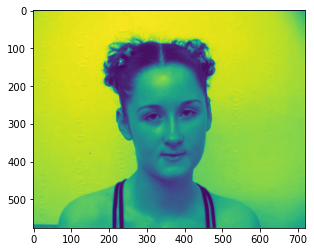

In [12]:
plt.imshow(X_train[0])

In [97]:
y_train[0]
print(X_train[0].shape)

(576, 720)


In [95]:
#P2: Obtenemos features de una imagen mediante ORB de CV2... Es mas rapido que SKIMAGE
def featureExtractor(image_list):
    desc=[]
    orb = cv2.ORB_create(nfeatures=100)
    for image in image_list:
        keypoints, descriptors = orb.detectAndCompute(image, None)
        desc.append(descriptors)
    return desc

In [42]:
#P2: Obtenemos features de una imagen mediante ORB de SKIMAGE... idealmente cambiar por SIFT 
#PROBLEMA: este descriptor es binario TRUE o FALSE, el de cv2 es con números no se el impacto de eso
def featureExtractor2(image_list):
    a=0
    desc=[]
    descriptor_extractor = ORB(n_keypoints=200)
    for image in image_list:
        descriptor_extractor.detect_and_extract(image)
        keypoints = descriptor_extractor.keypoints
        descriptors = descriptor_extractor.descriptors
        desc.append(descriptors)
    return desc


In [151]:
#P3
def getPatches(list):
    patches=[]
    X_size=144
    Y_size=180
    window_shape = (X_size, Y_size)
    for img in list:
        patch = extract_patches_2d(img,window_shape,max_patches=100)
        patches.append(patch)
    return patches

In [153]:
Xtrain_patches=getPatches(X_train)
Xtrain_patches=np.asarray(Xtrain_patches)
Xtrain_patches.shape

(479, 100, 144, 180)

In [142]:
#P4
Des=featureExtractor(X_train)

#Des2=featureExtractor2(X_train)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 2072896 bytes in function 'cv::OutOfMemoryError'


In [89]:
#Descriptores tienen shape=(100,32) supongo que hay que hacer un reshape para dejar todo en una sola columna
Des=np.asarray(Des)
Des=Des.reshape(479,100*32)
print(Des.shape)


(479, 3200)

In [91]:
#P5
def getClusters(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    centroids=kmeans.cluster_centers_
    return centroids


In [92]:
Clusters=getClusters(Des, 200)